In [54]:
#in v03, I am going to limit the options to games where both teams have sufficient data. 
#in v04, I am going to experiment with row combinations
#i think row combinations is the wrong approach. Going back to column.

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import time

In [2]:
from helper_functions.clean_transitions import clean_transition_column
from helper_functions.simulate_game import simulate_game

In [3]:
avg_matrix = pd.read_excel('avg_transition_matrix_with_manual_edits.xlsx', sheet_name = 'Mean Pasted', index_col='Starting_State')

In [4]:
# def combine_matrices(matrix_A, matrix_B, avg, params=[]):
#     pass

In [5]:
#limit games to sufficient data
all_games = os.listdir('raw_game_pulls')

In [6]:
games_meta_df = pd.DataFrame()
for g in all_games:
    game_strings = g.split(' vs ')
    team_A = game_strings[0].split('for ')[-1]
    team_B = game_strings[1].split('.xlsx')[0]
    games_meta_df = pd.concat([games_meta_df, pd.DataFrame({'Game':g,
                                                            'Team A':team_A,
                                                            'Team B':team_B}, index=[0])])

In [7]:
games_meta_df=games_meta_df.reset_index(drop=True)

In [8]:
# gmd2 = games_meta_df.copy()

In [9]:
# process_1_df = games_meta_df.copy()
# process_2_df = games_meta_df.copy()

In [10]:
# t1=time.time()
# for i in tqdm(range(100)):
# games_meta_df=process_1_df.copy()
team_A_count = games_meta_df\
    .groupby('Team A')['Game']\
        .count()\
            .reset_index()\
                .rename(columns={'Game':'Team A Count'})

team_B_count = games_meta_df\
    .groupby('Team B')['Game']\
        .count()\
            .reset_index()\
                .rename(columns={'Game':'Team B Count',
                                'Team B':'Team A'})

games_meta_df=games_meta_df.merge(team_A_count, on = 'Team A', how='left')
games_meta_df=games_meta_df.merge(team_B_count, on = 'Team A', how='left')
games_meta_df=games_meta_df.fillna(0)

games_meta_df['Team A Total Games'] = games_meta_df['Team A Count'] + games_meta_df['Team B Count']

games_meta_df=games_meta_df.drop(["Team A Count", 'Team B Count'], axis=1)

games_meta_df=games_meta_df.merge(team_A_count, left_on = 'Team B', right_on='Team A', how='left')
games_meta_df=games_meta_df.merge(team_B_count, left_on = 'Team B', right_on='Team A', how='left')
games_meta_df=games_meta_df.fillna(0)

games_meta_df['Team B Total Games'] = games_meta_df['Team A Count'] + games_meta_df['Team B Count']
games_meta_df=games_meta_df.drop(["Team A Count", 'Team B Count', 'Team A_y','Team A'], axis=1).rename(columns={'Team A_x': 'Team A'})
# t2=time.time()

In [11]:
#this was just to test looping method speed - was ~59x slower than groupby method
# unique_teams = pd.Series(list(gmd2['Team A']) + list(gmd2['Team B'])).unique()
# t3=time.time()
# for i in tqdm(range(100)):
#     gmd2=process_2_df.copy()
#     for t in unique_teams:
#         total_games = int(len(gmd2[gmd2['Team A']==t])) + int(len(gmd2[gmd2['Team B']==t]))
#         gmd2.loc[gmd2['Team A']==t, 'Team A Total Games'] = total_games
#         gmd2.loc[gmd2['Team B']==t, 'Team B Total Games'] = total_games
# t4=time.time()

In [12]:
n_cutoff = 20

In [13]:
games_to_consider = list(games_meta_df[(games_meta_df['Team A Total Games']>n_cutoff)&(games_meta_df['Team B Total Games']>n_cutoff)]['Game'].unique())

In [14]:
def accuracy(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    sim_A_score=[simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))]
    sim_B_score=[simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))]
    a_error = (real_A_score-sim_A_score)**2
    b_error = (real_B_score-sim_B_score)**2

    return np.mean(np.sqrt(a_error+b_error))

In [15]:
def accuracy_ou(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    real_total = real_A_score + real_B_score

    sim_A_score=[simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))]
    sim_B_score=[simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))]
    sim_total = np.array(list(map(lambda x,y: x+y, sim_B_score, sim_A_score)))


    return np.mean(sim_total-real_total)

In [16]:
def accuracy_winner(simulation_outcome, game_result):
    #when X = 1, this will only be 1 or 0
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    team_A_win = real_A_score > real_B_score

    sim_A_score=np.array([simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))])
    sim_B_score=np.array([simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))])
    sim_win = sim_A_score > sim_B_score


    return np.mean(team_A_win == sim_win)

In [60]:
# Define optimization problem
#need to adjust so that all of the algo's use the same games
def optimization_problem_v2(guesses, games_list, x=10):
    global g, guess, distance_score, ou_score, moneyline_score

    all_results=pd.DataFrame()
    
    for g in tqdm(games_list):

        #locate teams to find matrices
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')


        # Reshape the parameters into matrices
        for guess in range(len(guesses)):
            m1 = guesses[guess][:18]
            m2 = guesses[guess][18:36]
            m3 = guesses[guess][36:]

            # Construct combined matrix
            # combined_matrix = m1 * matrix1 + m2 * matrix2 + m3 * avg_matrix  # Adjust with scalar multiples
            combined_matrix = matrix1.mul(m1, axis=1) + matrix2.mul(m2,axis=1)+avg_matrix.mul(m3,axis=1)
            
            for r in combined_matrix.index:
                if combined_matrix.loc[r].sum()==0.:
                    combined_matrix.loc[r]=avg_matrix.loc[r].copy()
                
            combined_matrix = combined_matrix.div(combined_matrix.sum(axis=1), axis=0)
            combined_matrix.columns=avg_matrix.columns

            # Evaluate performance on X game simulations
            result = simulate_game(combined_matrix, x)



            distance_score = accuracy(result, game_res)
            ou_score = accuracy_ou(result, game_res)
            moneyline_score = accuracy_winner(result, game_res)

            all_results=pd.concat([all_results, pd.DataFrame({'Game':g,
                                                              'Guess':guess+1,
                                                              'Distance':distance_score,
                                                              'OU':ou_score,
                                                              'Moneyline':moneyline_score}, index=[0])])
    return all_results

In [61]:
# Initialize parameters
# initial_guess = np.random.rand(54)
    
initial_guess=   np.array([1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,
                    0,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

In [62]:
team_A_guess = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
team_B_guess = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
avg_guess = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
two_one = np.array([ 1, 1, 1, 1, 1, 1, 1, 1, 1,.5,.5,.5,.5,.5,.5,.5,.5,.5,
                    .5,.5,.5,.5,.5,.5,.5,.5,.5, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
overlay = team_A_guess + team_B_guess
overlay_and_avg = np.repeat(1,54)
overlay_with_revert = overlay + 0.1*avg_guess
halvsies = np.array([ 1, 1, 1, 1, 1, 1, 1, 1, 1,0,0,0,0,0,0,0,0,0,
                    0,0,0,0,0,0,0,0,0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
grinch = np.array([ 100, 1, 12, 74, 0, 1, 12, 1, 31,0,0,0,9,0,0,0,0,0,
                    9,0,22,0,4,0,.3,85,0, 1, 1, 1, 1, 43, 2, 1, 1, 1,
                    0,0,0,0,0,68,0,0,0,0,0,0,65,0,0,0,0,0])


In [63]:
t1_scale = two_one * 0.9 + 0.1*avg_guess
skibidi_pongus = np.random.rand(54)

In [64]:
guess_dict = {'Init':initial_guess,
              'Avg':avg_guess,
              'Two One':two_one,
              'Overlay':overlay,
              'Over Avg':overlay_and_avg,
              'Over Rev':overlay_with_revert,
              'Two One Rev':t1_scale,
              "Bad Guess":skibidi_pongus,
              'Half':halvsies,
              'Goingus':grinch}

In [85]:
all_guesses = list(guess_dict.values())
games = np.random.choice(os.listdir('raw_game_pulls'),10)

In [86]:
results=optimization_problem_v2(all_guesses, games, 10)

100%|██████████| 10/10 [01:50<00:00, 11.03s/it]


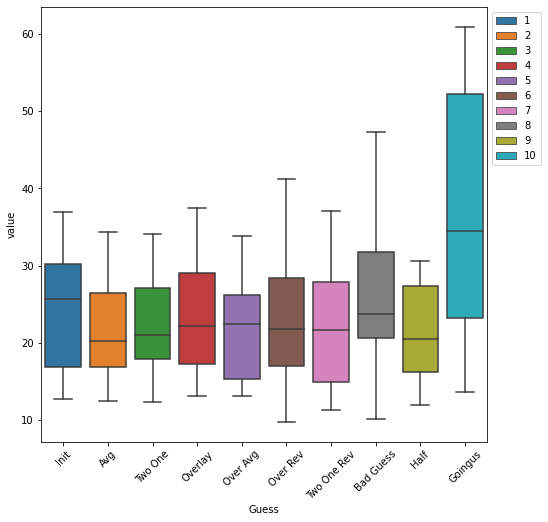

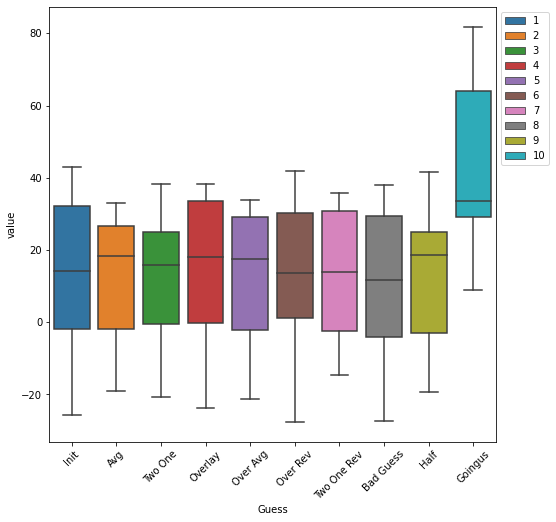

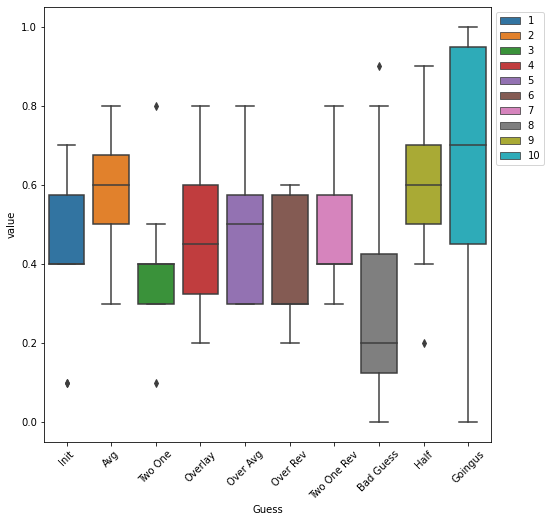

In [87]:
results_melt =results.melt(id_vars=['Game','Guess'])
for v in ['Distance','OU','Moneyline']:
    data =results_melt[results_melt['variable']==v]
    fig,ax = plt.subplots(figsize=(8,8))
    sns.boxplot(x='Guess',y='value', data = data, hue='Guess', dodge=False, )
    ax.set_xticklabels(list(guess_dict.keys()), rotation=45)
    ax.legend(bbox_to_anchor=(1,1))

In [88]:
results[results['Game']==list(results['Game'])[0]]

,Game,Guess,Distance,OU,Moneyline
0,6198967_Play-By-Play for Richmond vs St. Bonav...,1,32.021362,43.1,0.4
0,6198967_Play-By-Play for Richmond vs St. Bonav...,2,26.877822,32.9,0.5
0,6198967_Play-By-Play for Richmond vs St. Bonav...,3,31.283564,38.2,0.4
0,6198967_Play-By-Play for Richmond vs St. Bonav...,4,29.141919,38.2,0.8
0,6198967_Play-By-Play for Richmond vs St. Bonav...,5,26.251098,33.3,0.3
0,6198967_Play-By-Play for Richmond vs St. Bonav...,6,28.506743,33.2,0.3
0,6198967_Play-By-Play for Richmond vs St. Bonav...,7,28.406522,35.8,0.4
0,6198967_Play-By-Play for Richmond vs St. Bonav...,8,34.262176,38.0,0.1
0,6198967_Play-By-Play for Richmond vs St. Bonav...,9,30.647877,41.5,0.9
0,6198967_Play-By-Play for Richmond vs St. Bonav...,10,49.630689,67.0,1.0


In [102]:
game1=np.random.choice(games_to_consider)

In [104]:
game_res = pd.read_excel('raw_game_pulls/{}'.format(game1))
game_strings = g.split(' vs ')
team_A = game_strings[0].split('for ')[-1]
team_B = game_strings[1].split('.xlsx')[0]

matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')



In [113]:
guesses = [initial_guess  ] 
guess=0         
m1 = guesses[guess][:18]
m2 = guesses[guess][18:36]
m3 = guesses[guess][36:]

# Construct combined matrix
# combined_matrix = m1 * matrix1 + m2 * matrix2 + m3 * avg_matrix  # Adjust with scalar multiples
combined_matrix = matrix1.mul(m1, axis=1) + matrix2.mul(m2,axis=1)+avg_matrix.mul(m3,axis=1)

for r in combined_matrix.index:
    if combined_matrix.loc[r].sum()==0.:
        combined_matrix.loc[r]=avg_matrix.loc[r].copy()

combined_matrix = combined_matrix.div(combined_matrix.sum(axis=1), axis=0)
combined_matrix.columns=avg_matrix.columns

In [114]:
tots1=[]
tots2=[]
for i in range(100):
    abc=simulate_game(avg_matrix)
    ddd=simulate_game(combined_matrix)
    tots1.append(abc[1][0][0] + abc[1][0][1])
    tots2.append(ddd[1][0][0] + ddd[1][0][1])

In [117]:
home_score = game_res.iloc[-1]['Home']
away_score = game_res.iloc[-1]['Away']

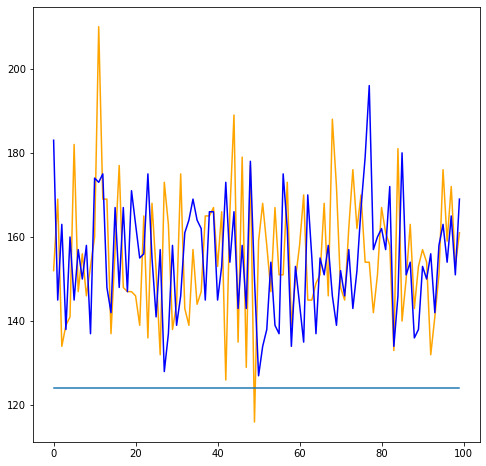

In [119]:
xs=range(100)
fig,ax=plt.subplots(figsize=(8,8))
meanline = np.repeat(home_score+away_score,len(xs))
plt.plot(xs,tots1, color='orange')
plt.plot(xs,tots2, color='blue')
plt.plot(xs,meanline)

(array([ 7., 11., 18., 26., 20., 12.,  3.,  2.,  0.,  1.]),
 array([127., 135., 143., 151., 159., 167., 175., 183., 191., 199., 207.]),
 <BarContainer object of 10 artists>)

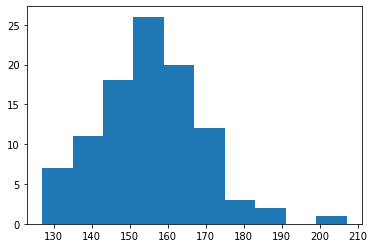

In [101]:
plt.hist(ys)